# FER-2013 Transfer Learning on MobileNetV2

We'll be going with FER-2013 this time which is a dataset containing, which contails 48x48 pixel grayscale images of faces tagged with their emotions.

We'll use MobileNetV2 here since the images are not too large, so it'll be efficinent to proceed this way.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

## Data Download and Extraction

Since the dataset is on kaggle, we'll first download and extract its contents here in colab.

In [2]:
!curl -L -C - -o ./fer2013.zip https://www.kaggle.com/api/v1/datasets/download/msambare/fer2013
!unzip -n ./fer2013.zip -d ./fer2013/

train_loc = "./fer2013/train/"
test_loc = "./fer2013/test/"

IMG_SIZE = 128 # To fit with MobileNetV2
BATCH_SIZE = 64
NUM_CLASSES = 7

Streaming output truncated to the last 5000 lines.
  inflating: ./fer2013/train/sad/Training_65242339.jpg  
  inflating: ./fer2013/train/sad/Training_65267116.jpg  
  inflating: ./fer2013/train/sad/Training_65275626.jpg  
  inflating: ./fer2013/train/sad/Training_6529266.jpg  
  inflating: ./fer2013/train/sad/Training_65329617.jpg  
  inflating: ./fer2013/train/sad/Training_65338712.jpg  
  inflating: ./fer2013/train/sad/Training_65338797.jpg  
  inflating: ./fer2013/train/sad/Training_65387162.jpg  
  inflating: ./fer2013/train/sad/Training_65404494.jpg  
  inflating: ./fer2013/train/sad/Training_65426218.jpg  
  inflating: ./fer2013/train/sad/Training_65430136.jpg  
  inflating: ./fer2013/train/sad/Training_65437377.jpg  
  inflating: ./fer2013/train/sad/Training_6545735.jpg  
  inflating: ./fer2013/train/sad/Training_65463385.jpg  
  inflating: ./fer2013/train/sad/Training_65473985.jpg  
  inflating: ./fer2013/train/sad/Training_65502829.jpg  
  inflating: ./fer2013/train/sad/Traini

## Data Generation and Augumentation

We'll perform some data augmentaion on the training data, and then proceed with creating train, test, and validation sets from the downloaded data.

In [3]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_gen = ImageDataGenerator(rescale=1./255)

In [4]:
train_data = train_gen.flow_from_directory(
    train_loc,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb", # To match MobileNetV2
    class_mode="categorical",
    subset="training",
    shuffle=True,
)

val_data = train_gen.flow_from_directory(
    train_loc,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb", # To match MobileNetV2
    class_mode="categorical",
    subset="validation",
    shuffle=False,
)

test_data = test_gen.flow_from_directory(
    test_loc,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb", # To match MobileNetV2
    class_mode="categorical",
    shuffle=False,
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


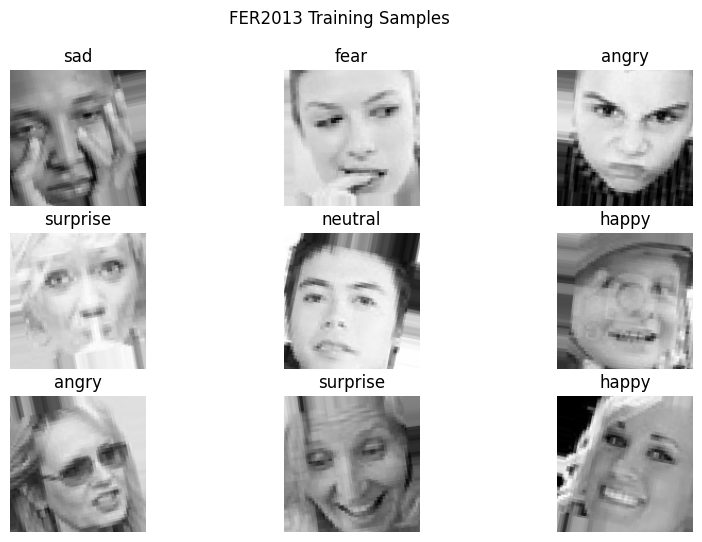

In [5]:
images, labels = next(train_data)
class_names = list(train_data.class_indices.keys())

plt.figure(figsize=(10,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.suptitle("FER2013 Training Samples")
plt.show()


## Implementing Class Weights

Since our data is highly imbalanced towards a lot of classes, we'll implement class weights to ensure uniformity.

In [6]:
class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(train_data.classes),
    y=train_data.classes
)

class_weights = dict(enumerate(class_weights))

## Building the Model

Now We'll proceed to build our Machine Learning Model on top of MobileNetV2.

In [7]:
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False #Transfer Learning

# We'll unfreeze the last 40 layers Partial Fine Tuning

for l in base_model.layers[-40:]:
  l.trainable = True

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [8]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,975 (9.26 MB)

 Trainable params: 1,848,967 (7.05 MB)

 Non-trainable params: 579,008 (2.21 MB)

## Training

We'll now proceed with training our model. We'll implement early stopping and reduceing LR on plateu.

In [9]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.3)
    ]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 177s 417ms/step - accuracy: 0.2759 - loss: 2.3854 - val_accuracy: 0.2522 - val_loss: 15.7968 - learning_rate: 0.0010
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 116s 324ms/step - accuracy: 0.4240 - loss: 1.5388 - val_accuracy: 0.2287 - val_loss: 4.3478 - learning_rate: 0.0010
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 115s 319ms/step - accuracy: 0.4702 - loss: 1.3991 - val_accuracy: 0.1249 - val_loss: 8.1149 - learning_rate: 0.0010
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 116s 324ms/step - accuracy: 0.4954 - loss: 1.3177 - val_accuracy: 0.3167 - val_loss: 2.3052 - learning_rate: 0.0010
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 116s 324ms/step - accuracy: 0.5103 - loss: 1.2753 - val_accuracy: 0.3668 - val_loss: 2.4657 - learning_rate: 0.0010
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 115s 320ms/step - accuracy: 0.5187 - loss: 1.2574 - val_accuracy: 0.3853 - val_loss: 2.1251 - learning_rate: 0.0010
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 115s 320ms/step - accur

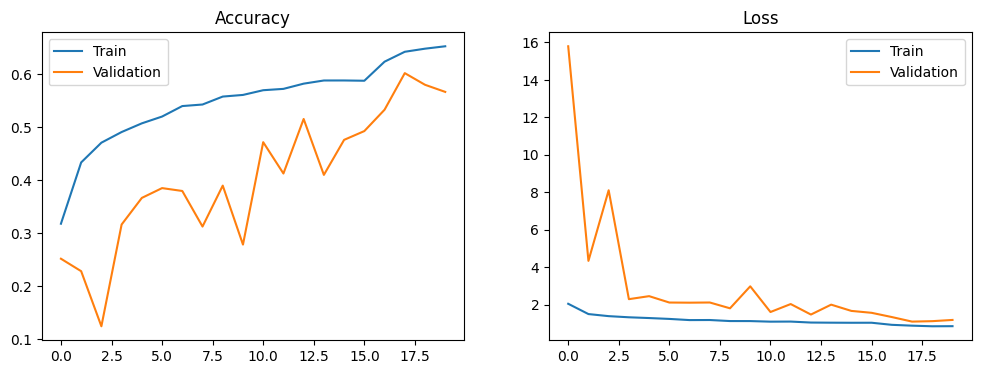

In [10]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()

plt.show()

## Evaluation

We'll now evaluate our model on some metrics.

In [11]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.5519 - loss: 1.1734
Test Accuracy: 0.6074


In [12]:
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes
class_names = list(test_data.class_indices.keys())

113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step


In [13]:
print(classification_report(y_true, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

       angry       0.56      0.45      0.50       958
     disgust       0.28      0.62      0.39       111
        fear       0.47      0.41      0.44      1024
       happy       0.82      0.84      0.83      1774
     neutral       0.56      0.56      0.56      1233
         sad       0.48      0.54      0.51      1247
    surprise       0.72      0.71      0.71       831

    accuracy                           0.61      7178
   macro avg       0.56      0.59      0.56      7178
weighted avg       0.61      0.61      0.61      7178



[[ 427   60  105   47  109  189   21]
 [  23   69    4    3    5    6    1]
 [ 109   36  422   36  107  208  106]
 [  34   13   41 1494   87   67   38]
 [  56   27   87   98  689  238   38]
 [  76   28  160   84  206  671   22]
 [  34   13   88   52   31   25  588]]


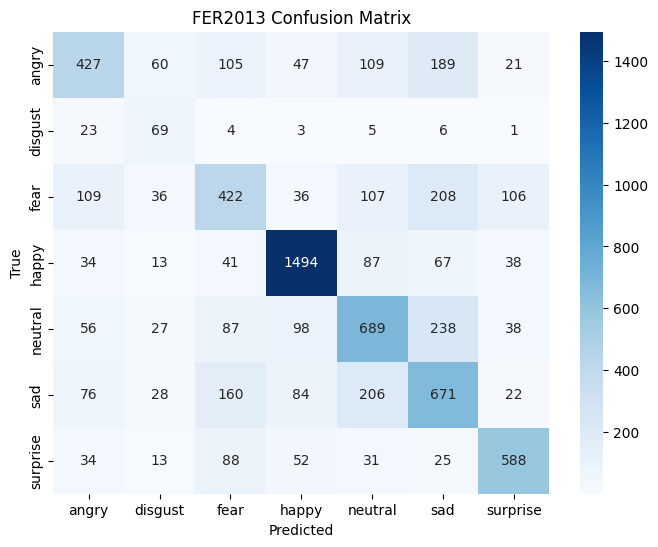

In [14]:
cm = confusion_matrix(y_true, y_pred_classes)

print(cm)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("FER2013 Confusion Matrix")
plt.show()


## Conclusion

Compared to other online models, our model performs fairly good with an accuracy of 61% and Macro F1 score of 0.56. By incorporating class weights, the results of diguist and fear imporved significantly since they had fewer numbers.

#